In [1]:
import os

os.chdir("../")

import torch
from nnsimplified.nn import (
    mlp,
    nnModular,
    nnParallel,
    embeddingModule,
    Concat,
    Split,
    Transpose,
    TensorSum,
    MatryoshkaLayer,
    addResidualConn1D,
)

# Multilayer Perceptron

In [2]:
mlp1 = mlp([128, 64, 32])  # simple construction (use defaults)

## can be further customized
# mlp1 = mlp(
#     nn_structure=[128, 64, 32, 8],
#     activation_setting='ReLU',
#     weight_init='kaiming_normal',
#     batchnorm_setting={
#         'eps': 1e-05,
#         'momentum': 0.1,
#         'affine': True,
#         'track_running_stats': True
#     },
#     dropout_rate=0.3
# )
print(mlp1)

mlp(
  (linear_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (activation): ReLU()
  (batchnorms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
  )
)


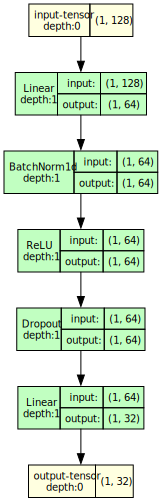

In [3]:
# visualize
mlp1.visualize()

# Autoencoder

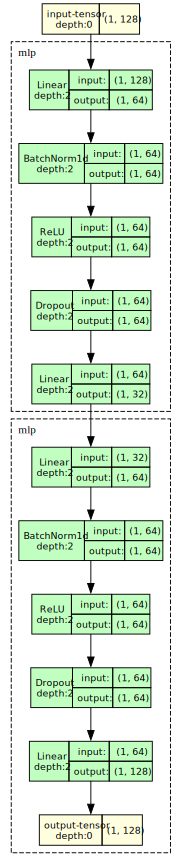

In [4]:
# construct encoder and decoder
encoder = mlp([128, 64, 32])
decoder = mlp([32, 64, 128])

# construct autoencoder using nnModular to connect the two (# output shape of the encoder module must match the input shape of the decoder module)

autoencoder = nnModular([encoder, decoder], copy_module=False)

# visualize
autoencoder.visualize()

In [5]:
# dummy data
dummy_input = encoder._create_dummy_input(batch_size=4)  # shape = (4,32)

# embed
encoder.eval()  # set evaluation mode
# get embeddings
with torch.no_grad():
    embeddings = encoder(dummy_input)

print(embeddings)

tensor([[-0.3238,  0.7945,  1.5192, -0.9354,  0.3315,  1.3433, -0.5555, -0.3936,
         -0.0379, -0.5502,  0.4888, -0.2834,  0.0563,  0.5722,  0.0349, -0.8163,
          1.2977, -0.8727,  0.1141,  0.9242,  0.2325,  0.5442, -0.0069,  1.2977,
         -0.9069,  0.9482, -0.1023, -1.5086,  0.5013, -0.8444,  0.2894, -0.2661],
        [ 1.4296, -0.1818,  2.0547, -0.8719,  0.2724,  1.2735, -0.1807,  0.1985,
         -0.7922, -0.8370, -0.4051, -0.3412, -0.0537,  0.1648,  0.5799, -0.5792,
          1.3480, -0.9334,  0.6953,  1.4121, -0.9989,  0.2408,  1.6594,  1.1322,
         -0.7563,  0.8867,  0.5397, -1.3884, -0.4661, -0.8194, -0.1545, -0.2135],
        [-0.6326, -0.3425,  1.6747, -0.4361,  0.8809,  1.3459, -0.2276, -0.2427,
         -0.4751, -0.4549,  0.4549, -0.4807, -0.5826, -0.0543,  0.0301, -0.6679,
          0.6708, -0.2351,  0.3307,  0.8490, -0.6434,  0.1391,  0.7797,  1.3495,
         -0.4097,  0.8934,  0.1295, -1.2183,  0.8523, -0.6769,  0.0326, -0.2256],
        [-1.0287,  0.5746

# Network with Categorical Embeddings

In [6]:
# create embedding layer (10 categories and each category is represented by a 32-dim vector)
embedding_layer = embeddingModule(
    n_categories=10, embedding_dim=32, input_data_shape=torch.Size([-1])
)

# get categorical embeddings
categories = torch.tensor([0, 2])  # feed in the first and the third categories

embedding_layer(categories)

tensor([[-2.2587, -1.3613, -1.4354, -2.4841,  0.8815, -0.5435,  1.1713,  1.4861,
         -0.1407, -0.3789, -1.0703,  0.1987, -0.1157,  0.2984, -0.0370,  0.8853,
          0.8503,  0.7664,  0.2050, -0.2712, -0.0797, -1.5102,  0.5209, -1.7635,
         -2.0140,  1.3238, -0.2614, -0.4748, -0.4171,  1.4629, -0.0580, -0.1230],
        [-1.5181, -0.3375, -1.0582,  0.8596, -1.3041,  0.3245,  1.2283,  0.3786,
          1.0595, -1.2790,  1.5674, -1.1922,  0.5306,  0.4532, -0.3092,  0.8507,
          0.9498, -0.8909, -1.8439, -0.3425, -1.9670, -3.2278, -1.2578, -0.5080,
          0.4596,  0.6270,  0.4078, -0.0310,  0.3983,  0.7043, -0.6908, -0.2286]],
       grad_fn=<EmbeddingBackward0>)

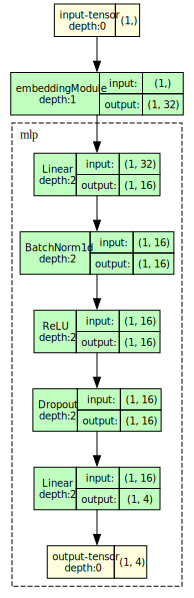

In [7]:
# Use nnModular to connect to a mlp (output shape of the embedding module must match the input shape of the mlp module)
model = nnModular(
    [
        embedding_layer,  # convert categorical input (0 to 9 in this case) to a 128-dim vector
        mlp([32, 16, 4]),  # input dim needs to match the ouput of previous module
    ]
)
model.visualize()

# Residual Network

In [8]:
mlp1 = mlp([64, 64, 64])
residual_mlp1 = addResidualConn1D(model=mlp1, skip_batchnorm_setting=None)

mlp2 = mlp([64, 32, 1])
residual_mlp2 = addResidualConn1D(model=mlp2, skip_batchnorm_setting=None)

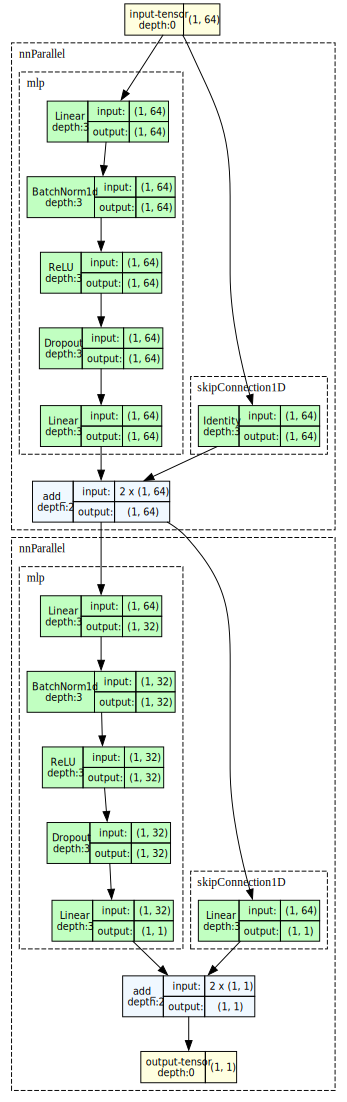

In [9]:
# connect modules using nnModular
model = nnModular([residual_mlp1, residual_mlp2])
model.visualize()

# Matryoshka Represenation

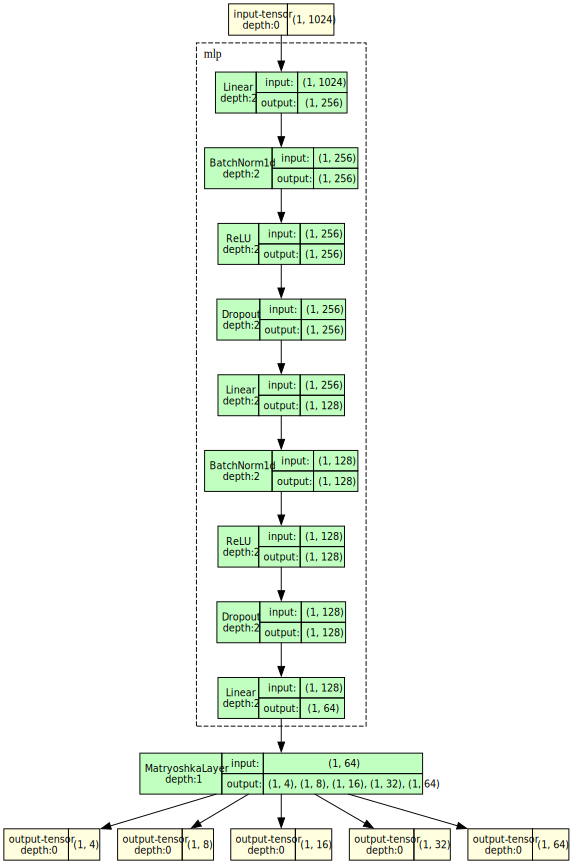

In [10]:
nnModular([mlp([1024, 256, 128, 64]), MatryoshkaLayer(min_size=4)]).visualize()

# Complex Network

## Parallel Module Construction

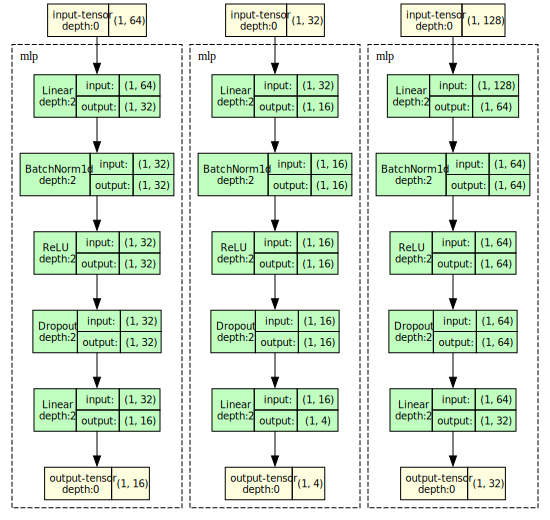

In [11]:
mlp1 = mlp([64, 32, 16])
mlp2 = mlp([32, 16, 4])
mlp3 = mlp([128, 64, 32])

# use nnParalell to combine all 3 models in parallel into 1 model
model = nnParallel([mlp1, mlp2, mlp3])
model.visualize()

In [12]:
print("Input data shape:", model.input_shape)
print("Output data shape:", model.input_shape)

Input data shape: (torch.Size([-1, 64]), torch.Size([-1, 32]), torch.Size([-1, 128]))
Output data shape: (torch.Size([-1, 64]), torch.Size([-1, 32]), torch.Size([-1, 128]))


## Connecting modules (in series)

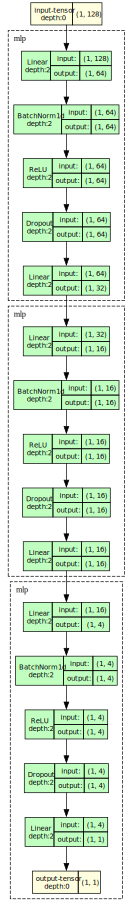

In [13]:
model = nnModular([mlp([128, 64, 32]), mlp([32, 16, 16]), mlp([16, 4, 1])])
model.visualize()

# Use nnParallel and nnModular to create complex structure

/Users/dennis/Project Repos/nnSimplified/nnsimplified/nn/module/assemble.py:174: RuntimeWarning: Unable to determine the required input data shape for the following modules: ['ReLU', 'Sigmoid']. Since we cannot check the integrity of the structure, please proceed with caution.
  warnings.warn(warning_text, RuntimeWarning)


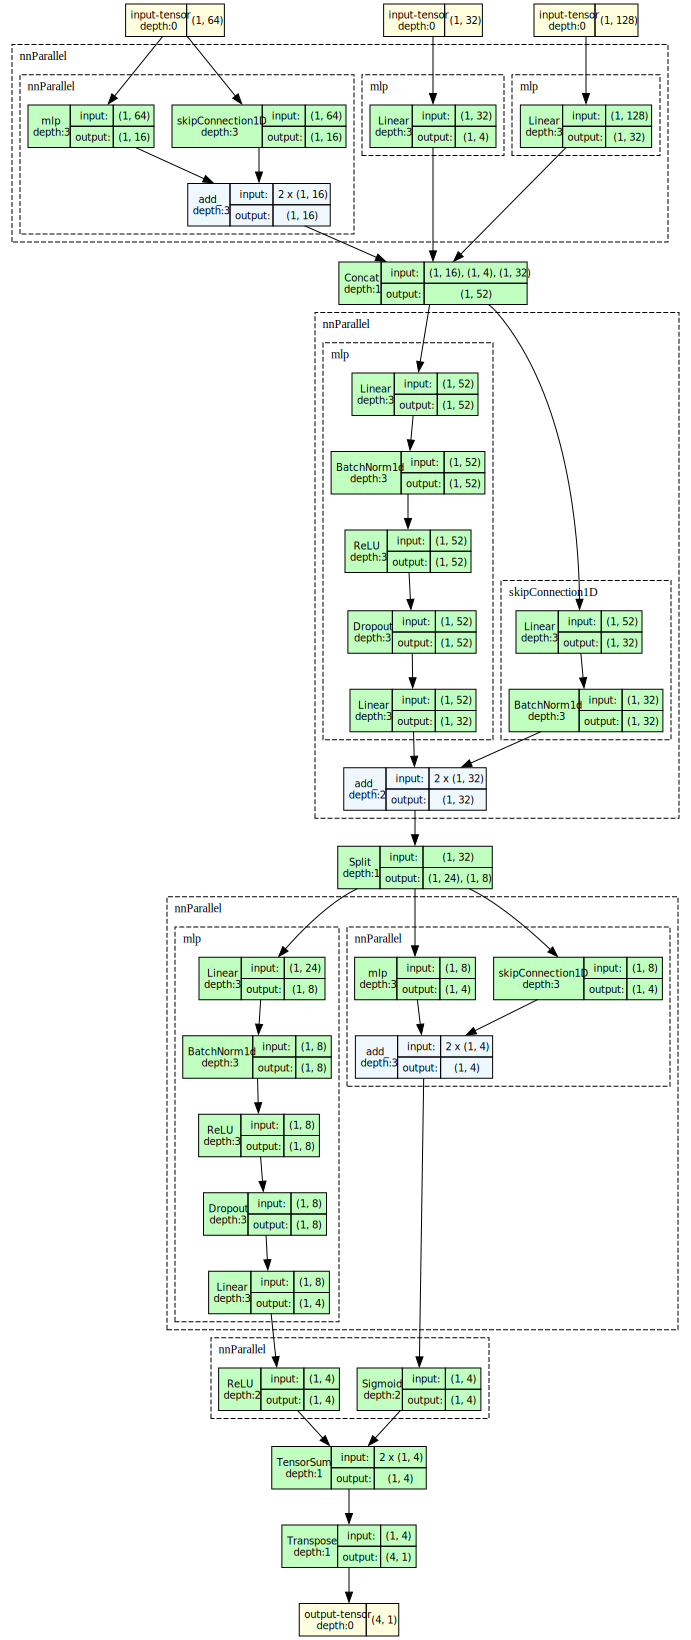

In [14]:
model = nnModular(
    [
        nnParallel([addResidualConn1D(mlp([64, 16])), mlp([32, 4]), mlp([128, 32])]),
        Concat(-1),  # concatenate in dim=-1
        addResidualConn1D(mlp([52, 52, 32])),
        Split([24, 8], dim=-1),  # split in to 24 and 8 in dimension=-1
        [
            mlp([24, 8, 4]),
            addResidualConn1D(mlp([8, 4, 4])),
        ],  # use [] to combine multiple modules in parallel; same as nnParallel([...])
        [
            torch.nn.modules.ReLU(),
            torch.nn.modules.Sigmoid(),
        ],  # compatible with torch modules
        TensorSum(),  # concatenate
        Transpose(dim0=-1, dim1=-2),  # transpose
    ]
)
model.visualize()